<img src="../figures/fluxml.png" width=400 height=140>

# Working with Flux

In [1]:
using Flux, Statistics, FileIO, Images
using MLJ: partition
using Plots

IJuliaAppend::IJuliaBehavior = 2

In [23]:
# load in the data
cats = channelview.([load("../datasets/cats/cat/"*img) for img in readdir("../datasets/cats/cat")]);
loafs = channelview.([load("../datasets/cats/loaf/"*img) for img in readdir("../datasets/cats/loaf")]); 
cats = [permutedims(c, (2,3,1)) for c in cats];
loafs = [permutedims(c, (2,3,1)) for c in loafs];
cats = cat(cats...,dims=4);
loafs = cat(loafs..., dims=4);

In [24]:
train_cats, valid_cats, test_cats = partition(1:size(cats, 4), 0.8, 0.1, rng=125)
train_loafs, valid_loafs, test_loafs = partition(1:size(loafs, 4), 0.8, 0.1, rng=125);

In [25]:
train_set = Float32.(cat(cats[:,:,:,train_cats], loafs[:,:,:,train_loafs], dims=4));
train_labels = repeat([0; 1],inner=size(train_set, 4)÷2);

valid_set = Float32.(cat(cats[:,:,:,valid_cats], loafs[:,:,:,valid_loafs], dims=4));
valid_labels = repeat([0; 1],inner=size(valid_set, 4)÷2);

test_set = Float32.(cat(cats[:,:,:,test_cats], loafs[:,:,:,test_loafs], dims=4));
test_labels = repeat([0; 1],inner=size(test_set, 4)÷2);

In [38]:
# define the network
model = Chain(
  Conv((3,3), 3 => 3, relu, stride=2),
  MaxPool((3,3)),
  Conv((3,3), 3 => 3, relu, stride=2),
  MaxPool((3,3)),
  Flux.flatten,
  Dense(12 => 2)
)

#Flux.outputsize(model, (100,100,3,1))

(2, 1)

In [39]:
targets = Flux.onehotbatch(train_labels, [0, 1])
val_targets = Flux.onehotbatch(valid_labels, [0, 1])
sources = Flux.DataLoader((train_set, targets), batchsize = 32, shuffle = true)

17-element DataLoader(::Tuple{Array{Float32, 4}, OneHotArrays.OneHotMatrix{UInt32, Vector{UInt32}}}, shuffle=true, batchsize=32)
  with first element:
  (100×100×3×32 Array{Float32, 4}, 2×32 OneHotMatrix(::Vector{UInt32}) with eltype Bool,)

In [40]:
optim = Flux.setup(Flux.Adam(0.01), model);

┌ Info: Saved animation to /Users/max/TUe/Julia-sysbio-workshop/figures/losscurve.gif
└ @ Plots /Users/max/.julia/packages/Plots/3BCH5/src/animation.jl:156


Plots.AnimatedGif("/Users/max/TUe/Julia-sysbio-workshop/figures/losscurve.gif")
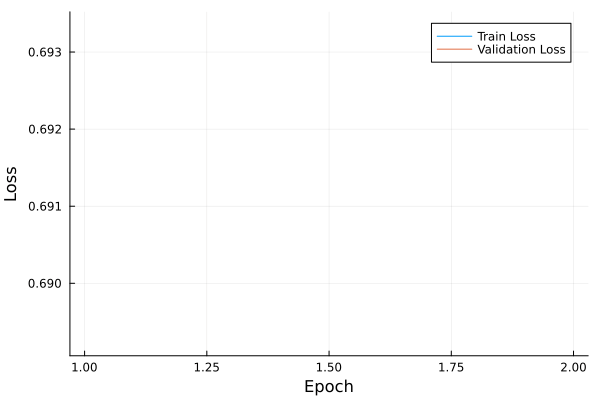

In [41]:
losses = []
val_losses = []

anim = @animate for epoch in 1:50
  #println("Epoch $(epoch) of $(100):")
  epoch_loss = []
  for (x, y) in sources
    loss, grads = Flux.withgradient(model) do m
      ŷ = m(x)
      Flux.logitcrossentropy(ŷ, y)
    end
    Flux.update!(optim, model, grads[1])
    push!(epoch_loss, loss)
  end
  
  ŷ_val = model(valid_set)
  val_loss = Flux.logitcrossentropy(ŷ_val, val_targets)
  push!(losses, mean(epoch_loss))
  push!(val_losses, val_loss)

  pl = plot(losses, xlabel="Epoch", ylabel="Loss", label="Train Loss")
  plot!(pl, val_losses, label="Validation Loss")
end

gif(anim, "../figures/losscurve.gif", fps=5)

In [9]:
using Metalhead

pretrained_model = ResNet(18; pretrain=true);

┌ Warning: Package cuDNN not found in current path.
│ - Run `import Pkg; Pkg.add("cuDNN")` to install the cuDNN package, then restart julia.
│ - If cuDNN is not installed, some Flux functionalities will not be available when running on the GPU.
└ @ FluxCUDAExt /Users/max/.julia/packages/Flux/pR3k3/ext/FluxCUDAExt/FluxCUDAExt.jl:48


In [10]:
TFModel = 
Chain(
  backbone = backbone(pretrained_model),
  classifier = Chain(
    AdaptiveMeanPool((1,1)),
    Flux.flatten,
    Dense(512 => 2)
  )
)

#TFModel.layers

Chain(
  backbone = Chain(
    Chain(
      Conv((7, 7), 3 => 64, pad=3, stride=2, bias=false),  # 9_408 parameters
      BatchNorm(64, relu),              # 128 parameters, plus 128
      MaxPool((3, 3), pad=1, stride=2),
    ),
    Chain(
      Parallel(
        addact(NNlib.relu, ...),
        identity,
        Chain(
          Conv((3, 3), 64 => 64, pad=1, bias=false),  # 36_864 parameters
          BatchNorm(64),                # 128 parameters, plus 128
          NNlib.relu,
          Conv((3, 3), 64 => 64, pad=1, bias=false),  # 36_864 parameters
          BatchNorm(64),                # 128 parameters, plus 128
        ),
      ),
      Parallel(
        addact(NNlib.relu, ...),
        identity,
        Chain(
          Conv((3, 3), 64 => 64, pad=1, bias=false),  # 36_864 parameters
          BatchNorm(64),                # 128 parameters, plus 128
          NNlib.relu,
          Conv((3, 3), 64 => 64, pad=1, bias=false),  # 36_864 parameters
          BatchNorm(64),          

In [11]:
optim = Flux.setup(Flux.Adam(0.01), TFModel);
Flux.freeze!(optim.layers[:backbone])

In [12]:
losses = []
val_losses = []

anim = @animate for epoch in 1:50
  println("Epoch $(epoch) of $(100):")
  epoch_loss = []
  for (x, y) in sources
    loss, grads = Flux.withgradient(TFModel) do m
      ŷ = m(x)
      Flux.logitcrossentropy(ŷ, y)
    end
    Flux.update!(optim, TFModel, grads[1])
    push!(epoch_loss, loss)
  end
  
  ŷ_val = model(valid_set)
  val_loss = Flux.logitcrossentropy(ŷ_val, val_targets)
  push!(losses, mean(epoch_loss))
  push!(val_losses, val_loss)

  pl = plot(losses, xlabel="Epoch", ylabel="Loss", label="Train Loss")
  plot!(pl, val_losses, label="Validation Loss")
end

gif(anim, "../figures/losscurve.gif", fps=5)

Epoch 1 of 100:


Epoch 2 of 100:


Epoch 3 of 100:


Epoch 4 of 100:


Epoch 5 of 100:


Epoch 6 of 100:


Epoch 7 of 100:


Epoch 8 of 100:


Epoch 9 of 100:


Epoch 10 of 100:


Epoch 11 of 100:


Epoch 12 of 100:


Epoch 13 of 100:


fatal: error thrown and no exception handler available.
InterruptException()
sigatomic_end at ./c.jl:452 [inlined]
task_done_hook at ./task.jl:670
jfptr_task_done_hook_50473 at /Users/max/.julia/juliaup/julia-1.9.0+0.aarch64.apple.darwin14/lib/julia/sys.dylib (unknown line)
ijl_apply_generic at /Users/max/.julia/juliaup/julia-1.9.0+0.aarch64.apple.darwin14/lib/julia/libjulia-internal.1.9.dylib (unknown line)
jl_finish_task at /Users/max/.julia/juliaup/julia-1.9.0+0.aarch64.apple.darwin14/lib/julia/libjulia-internal.1.9.dylib (unknown line)
start_task at /Users/max/.julia/juliaup/julia-1.9.0+0.aarch64.apple.darwin14/lib/julia/libjulia-internal.1.9.dylib (unknown line)
┌ Warning: temp cleanup
│   exception = (ErrorException("schedule: Task not runnable"), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x000000011aa1d46b, Ptr{Nothing} @0x000000011aa1f78b, Ptr{Nothing} @0x000000011a6fc83f, Ptr{Nothing} @0x000000011a6db7d3, Ptr{Nothing} @0x000000011a6dbc37, Ptr{Nothing} @0x000000011a

ErrorException: schedule: Task not runnable

In [13]:
losses

12-element Vector{Any}:
 1.3935096f0
 0.52222955f0
 0.43347254f0
 0.38797736f0
 0.31732407f0
 0.49079973f0
 0.37696984f0
 0.37148118f0
 0.5838271f0
 0.68447447f0
 0.64393735f0
 0.25181964f0

In [14]:
val_losses

12-element Vector{Any}:
 1.5258915f0
 1.5258915f0
 1.5258915f0
 1.5258915f0
 1.5258915f0
 1.5258915f0
 1.5258915f0
 1.5258915f0
 1.5258915f0
 1.5258915f0
 1.5258915f0
 1.5258915f0